In [2]:
import swiftemulator as se
from swiftemulator.design import latin
from swiftemulator.emulators import gaussian_process
from swiftemulator.emulators import multi_gaussian_process
from swiftemulator.mean_models.linear import LinearMeanModel
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.special import erf
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import StrMethodFormatter, NullFormatter
import matplotlib.patheffects as path_effects
import matplotlib as mpl
from scipy.ndimage import gaussian_filter1d
import illustris_python as il
import pickle
from scipy.optimize import curve_fit
from swiftemulator.comparison.penalty import L1PenaltyCalculator

# Universal constants
c = 2.99792458e10          # Speed of light [cm/s]
kB = 1.380648813e-16       # Boltzmann's constant [g cm^2/s^2/K]
h = 6.626069573e-27        # Planck's constant [erg/s]
mH = 1.6735327e-24         # Mass of hydrogen atom [g]
me = 9.109382917e-28       # Electron mass [g]
ee = 4.80320451e-10        # Electron charge [g^(1/2) cm^(3/2) / s]

# Emperical unit definitions
Msun = 1.988435e33         # Solar mass [g]
Lsun = 3.839e33            # Solar luminosity [erg/s]
Zsun = 0.0134              # Solar metallicity (mass fraction)
arcsec = 648000. / np.pi   # arseconds per radian
pc = 3.085677581467192e18  # Units: 1 pc  = 3e18 cm
kpc = 1e3 * pc             # Units: 1 kpc = 3e21 cm
Mpc = 1e6 * pc             # Units: 1 Mpc = 3e24 cm
km = 1e5                   # Units: 1 km  = 1e5  cm
angstrom = 1e-8            # Units: 1 angstrom = 1e-8 cm
day = 86400.               # Units: 1 day = 24 * 3600 seconds
yr = 365.24 * day          # Units: 1 year = 365.24 days
kyr = 1e3 * yr             # Units: 1 Myr = 10^6 yr
Myr = 1e6 * yr             # Units: 1 Myr = 10^6 yr
lambda_1216 = 1215.67 * angstrom # Lyman-alpha wavelength [cm]
lambda_1500 = 1500. * angstrom # Continuum wavelength [cm]
lambda_2500 = 2500. * angstrom # Continuum wavelength [cm]
R_10pc = 10. * pc              # Reference distance for continuum [cm]
fnu_1216_fac = lambda_1216**2 / (4. * np.pi * c * R_10pc**2 * angstrom)
fnu_1500_fac = lambda_1500**2 / (4. * np.pi * c * R_10pc**2 * angstrom)
fnu_2500_fac = lambda_2500**2 / (4. * np.pi * c * R_10pc**2 * angstrom)
E_AGN = 5.29e-11 # Mean photon energy [erg]
E_Lya = h * c / lambda_1216 # Lyman-alpha energy [erg]

In [3]:
def calc_hist(data, n_0=7, n_max=50000, reverse=True, use_median=True, factor=1.5):
    y = np.sort(data)
    if reverse:
        y = y[::-1] # Start from high mass end
    n_y = len(y)
    n_c = n_i = n_0
    n_bins = 1
    while n_c < n_y:
        n_i = min(int(factor * n_i), n_max, n_y - n_c)
        n_c += n_i
        n_bins += 1
    y_edges = np.zeros(n_bins+1)
    y_avg = np.zeros(n_bins)
    y_num = np.zeros(n_bins)
    y_edges[1] = 0.5 * (y[n_0-1] + y[n_0])
    y_edges[0] = y[0] + (y[n_0-1] - y_edges[1])
    y_avg[0] = np.median(y[0:n_0]) if use_median else np.mean(y[0:n_0])
    y_num[0] = n_0
    if reverse:
        assert y[n_0-1] > y[n_0]
        assert y_edges[0] > y[0]
    else:
        assert y[n_0-1] < y[n_0]
        assert y_edges[0] < y[0]
    n_c = n_i = n_0
    i_bin = 1
    while n_c < n_y:
        n_i = min(int(factor * n_i), n_max, n_y - n_c)
        y_edges[i_bin] = 0.5 * (y[n_c-1] + y[n_c])
        y_avg[i_bin] = np.median(y[n_c:n_c+n_i]) if use_median else np.mean(y[n_c:n_c+n_i])
        y_num[i_bin] = n_i
        n_c += n_i
        i_bin += 1
    y_edges[-1] = y[-1]
#     if False:
#         y_edges[-2] = y_edges[-1]
#         y_avg[-2] = (y_avg[-2]*y_num[-2] + y_avg[-1]*y_num[-1]) / (y_num[-2] + y_num[-1])
#         y_num[-2] = y_num[-2] + y_num[-1]
#         y_edges = y_edges[:-1]
#         y_avg = y_avg[:-1]
#         y_num = y_num[:-1]
    dy = y_edges[1:] - y_edges[:-1]
    if reverse:
        dy = -dy
#     print(n_bins)
#     print(np.sum(y_num)-n_y)
    return y_avg, y_num/dy, np.sqrt(y_num)/dy

In [4]:
def read_Lya(snap=70, sim='Thesan-1'):
    print(f'Reading snapshot {snap} ...')
    basePath = f'/nfs/mvogelsblab001/Thesan/{sim}/output'
    fields = ['SubhaloMass','SubhaloSFRinRad', 'SubhaloLenType', 'SubhaloMassType', 'SubhaloVelDisp', 'SubhaloPos', 'SubhaloGrNr']
#     fields = ['SubhaloLenType', 'SubhaloMass', 'SubhaloMassInRadType', 'SubhaloStellarPhotometrics', 'SubhaloStarMetallicity']
#   'SubhaloSFRinRad', 'SubhaloCM', 'SubhaloPos', 'SubhaloVel', 'SubhaloVelDisp']
    s = il.groupcat.loadSubhalos(basePath, snap, fields=fields)

    s['snap'] = snap
    s['basePath'] = basePath
    Lya_filename = basePath + f'/../postprocessing/Lya/Lya_{snap:03d}.hdf5'
    with h5py.File(Lya_filename, 'r') as f:
        g = f['Header']
        for key in ['BoxSize', 'EscapeFraction', 'Omega0', 'OmegaBaryon', 'OmegaLambda', 'HubbleParam', 'Time', 'Redshift']:
            s[key] = g.attrs[key]
#         BoxSize = g.attrs['BoxSize']
#         EscapeFraction = g.attrs['EscapeFraction']
#         Omega0 = g.attrs['Omega0']
#         OmegaBaryon = g.attrs['OmegaBaryon']
#         OmegaLambda = g.attrs['OmegaLambda']
        h = g.attrs['HubbleParam']
        a = g.attrs['Time']
        z = g.attrs['Redshift']
        UnitLength_in_cm = g.attrs['UnitLength_in_cm']
        UnitMass_in_g = g.attrs['UnitMass_in_g']
        UnitVelocity_in_cm_per_s = g.attrs['UnitVelocity_in_cm_per_s']
        UnitTime_in_s = UnitLength_in_cm / UnitVelocity_in_cm_per_s
        UnitEnergy_in_cgs = UnitMass_in_g * UnitVelocity_in_cm_per_s * UnitVelocity_in_cm_per_s
        UnitLum_in_cgs = UnitEnergy_in_cgs / UnitTime_in_s
        length_to_cgs = a * UnitLength_in_cm / h
        length_to_kpc = length_to_cgs / kpc
        volume_to_cgs = length_to_cgs * length_to_cgs * length_to_cgs
        s['BoxSize_Mpc'] = s['BoxSize'] * length_to_cgs / Mpc # Box size in Mpc (physical)
        s['V_box_Mpc3'] = s['BoxSize_Mpc']**3 # Box volume in Mpc^3 (physical)
        s['V_box_cMpc3'] = s['V_box_Mpc3'] / s['Time']**3
        mass_to_cgs = UnitMass_in_g / h
        mass_to_Msun = mass_to_cgs / Msun

        s['SubhaloMass'] = mass_to_Msun * s['SubhaloMass'] # Msun
        s['Lya'] = UnitLum_in_cgs * f['Subhalo']['LyaLum'][:].astype(np.float64) # Lya = LyaCol + LyaRec + LyaStars
#         s['LyaCol'] = UnitLum_in_cgs * f['Subhalo']['LyaLumCol'][:].astype(np.float64) # erg/s
#         s['LyaRec'] = UnitLum_in_cgs * f['Subhalo']['LyaLumRec'][:].astype(np.float64) # erg/s
#         s['LyaStars'] = UnitLum_in_cgs * f['Subhalo']['LyaLumStars'][:].astype(np.float64) # erg/s
#         s['L1216'] = UnitLum_in_cgs * f['Subhalo']['1216LumStars'][:].astype(np.float64) # erg/s/Angstrom
#         s['L1500'] = UnitLum_in_cgs * f['Subhalo']['1500LumStars'][:].astype(np.float64) # erg/s/Angstrom
#         s['L2500'] = UnitLum_in_cgs * f['Subhalo']['2500LumStars'][:].astype(np.float64) # erg/s/Angstrom
#         s['IonAGN'] = UnitLum_in_cgs * f['Subhalo']['IonLumAGN'][:].astype(np.float64) # erg/s
#         mask = (s['IonAGN'] > 0.)
#         y_AGN = s['IonAGN'][mask] / E_AGN # AGN ionizing photon rate [photons/s]
#         y_stars = s['LyaStars'][mask] / (0.68 * E_Lya * (1. - s['EscapeFraction'])) # Star ionizing photon rate [photons/s]
#         s['f_AGN'] = y_AGN / (y_AGN + y_stars)
#         s['M1216'] = -2.5 * np.log10(fnu_1216_fac * s['L1216']) - 48.6 # Continuum absolute magnitude
#         s['M1500'] = -2.5 * np.log10(fnu_1500_fac * s['L1500']) - 48.6 # Continuum absolute magnitude
#         s['M2500'] = -2.5 * np.log10(fnu_2500_fac * s['L2500']) - 48.6 # Continuum absolute magnitude
#         s['LyaVelDisp'] = f['Subhalo']['LyaVelDisp'][:][mask].astype(np.float64) # km/s
        
        # remove low LyaLum values
        mask = (s['Lya'] > 10**41.5)
        s['Lya'] = s['Lya'][mask]
        for field in fields:
            s[field] = s[field][mask]
        # remove high LyaLum values
        mask = (s['Lya'] < 10**45)
        s['Lya'] = s['Lya'][mask]
        for field in fields:
            s[field] = s[field][mask]
        
    return s

In [5]:
# z = 6.6
taylor_loglum = np.array([43.625, 43.875])
taylor_logphi = np.array([-5.940, -6.365])
taylor_phi = 10**taylor_logphi
taylor_loglowdiff = np.array([0.198, 0.374])
taylor_loghighdiff = np.array([0.131, 0.189])
taylor_loglow = taylor_logphi-taylor_loglowdiff
taylor_low = 10**taylor_loglow
taylor_loghigh = taylor_logphi+taylor_loghighdiff
taylor_high = 10**taylor_loghigh
taylor_lowdiff = taylor_phi-taylor_low
taylor_highdiff = taylor_high-taylor_phi

# z = 6.6
santos_loglum = np.array([42.61, 42.81, 43.01, 43.21, 43.41, 43.61, 43.81])
santos_logphi = np.array([-3.18, -3.32, -3.74, -4.10, -4.60, -4.97, -5.51])
santos_phi = 10**santos_logphi
santos_loghighdiff = np.array([0.08, 0.08, 0.09, 0.10, 0.14, 0.14, 0.20])
santos_loglowdiff = np.array([0.09, 0.08, 0.10, 0.11, 0.16, 0.16, 0.26])
santos_loglow = santos_logphi-santos_loglowdiff
santos_low = 10**santos_loglow
santos_loghigh = santos_logphi+santos_loghighdiff
santos_high = 10**santos_loghigh
santos_lowdiff = santos_phi-santos_low
santos_highdiff = santos_high-santos_phi

# z = 6.6
konno_loglum = np.array([43.15, 43.25, 43.35, 43.45, 43.55, 43.65, 43.75, 43.85])
konno_logphi = np.array([-4.194, -4.407, -4.748, -5.132, -5.433, -5.609, -6.212, -6.226])
konno_phi = 10**konno_logphi
konno_loghighdiff = np.array([0.154, 0.101, 0.087, 0.140, 0.203, 0.253, 0.519, 0.519])
konno_loglowdiff = np.array([0.317, 0.258, 0.243, 0.300, 0.374, 0.438, 0.917, 0.917])
konno_loglow = konno_logphi-konno_loglowdiff
konno_low = 10**konno_loglow
konno_loghigh = konno_logphi+konno_loghighdiff
konno_high = 10**konno_loghigh
konno_lowdiff = konno_phi-konno_low
konno_highdiff = konno_high-konno_phi

# z = 6.6
ouchi_loglum = np.array([42.5000, 42.7000, 42.9000, 43.1000, 43.5000])
ouchi_phi = np.array([0.000977984, 0.000600671, 0.000275728, 5.55873e-05, 8.77031e-06])
ouchi_lowdiff = np.array([0.000253014, 0.000100953, 5.29373e-05, 3.87408e-05, 8.77030e-06])
ouchi_highdiff = np.array([0.000470505, 0.000250868, 0.000119775, 4.37947e-05, 8.77031e-06])
ouchi_low = ouchi_phi-ouchi_lowdiff
ouchi_high = ouchi_phi+ouchi_highdiff

## for plot with diff colors for diff observations ##
# phi
log_ouchi_phi = np.log10(ouchi_phi)
log_konno_phi = konno_logphi
log_santos_phi = santos_logphi
log_taylor_phi = taylor_logphi
# lum
log_ouchi_lum = ouchi_loglum
log_konno_lum = konno_loglum
log_santos_lum = santos_loglum
log_taylor_lum = taylor_loglum
# lowdiff
log_ouchi_low = np.log10(ouchi_low)
log_ouchi_low[-1] = -5.75
log_ouchi_lowdiff = log_ouchi_phi - log_ouchi_low
log_konno_lowdiff = konno_loglowdiff
log_santos_lowdiff = santos_loglowdiff
log_taylor_lowdiff = taylor_loglowdiff
# highdiff
log_ouchi_high = np.log10(ouchi_high)
log_ouchi_highdiff = log_ouchi_high - log_ouchi_phi
log_konno_highdiff = konno_loghighdiff
log_santos_highdiff = santos_loghighdiff
log_taylor_highdiff = taylor_loghighdiff

## uncorrected
# phi
phi_obs = np.concatenate((taylor_phi, santos_phi, konno_phi, ouchi_phi))
log_phi_obs = np.log10(phi_obs)
# lum
log_L_obs = np.concatenate((taylor_loglum, santos_loglum, konno_loglum, ouchi_loglum))
# err
low_obs = np.concatenate((taylor_low, santos_low, konno_low, ouchi_low))
high_obs = np.concatenate((taylor_high, santos_high, konno_high, ouchi_high))
err_obs = (high_obs - low_obs) / 2.
log_low_obs = np.log10(low_obs)
log_high_obs = np.log10(high_obs)
log_lowdiff_obs = log_phi_obs - log_low_obs
log_highdiff_obs = log_high_obs - log_phi_obs
log_err_obs = (log_high_obs - log_low_obs) / 2.

# making sure observations are sorted by increasing luminosity
observations_dict = {}
for i in range(len(log_L_obs)):
    observations_dict[log_L_obs[i]] = [log_phi_obs[i], log_err_obs[i]]
log_L_obs_sorted = np.sort(log_L_obs)
log_phi_obs_sorted = np.zeros(len(log_phi_obs))
log_err_obs_sorted = np.zeros(len(log_err_obs))
for i in range(len(log_L_obs)):
    log_phi_obs_sorted[i] = observations_dict[log_L_obs_sorted[i]][0]
    log_err_obs_sorted[i] = observations_dict[log_L_obs_sorted[i]][1]

# fit schechter function
def schechter(log_M, log_phi, log_M0, alpha):
    log_M_diff = log_M - log_M0
    phi = 10**log_phi
    return phi * (10.0 ** ((alpha + 1.0) * (log_M_diff))) * np.exp(-(10.0 ** log_M_diff))

def log_schechter(log_M, log_phi, log_M0, alpha):
    return np.log10(schechter(log_M, log_phi, log_M0, alpha))

popt, pcov = curve_fit(
    log_schechter, log_L_obs_sorted, log_phi_obs_sorted, p0=(log_phi_obs_sorted[0], 42, -1.0), sigma=log_err_obs_sorted, absolute_sigma=True
)
print(popt)
log_phi_schechter_fit = log_schechter(log_L_obs_sorted, *popt)

log_phi_schechter_fit_6 = log_phi_schechter_fit
log_L_obs_sorted_6 = log_L_obs_sorted
log_L_obs_6 = log_L_obs
log_phi_obs_6 = log_phi_obs
log_phi_obs_sorted_6 = log_phi_obs_sorted
log_lowdiff_obs_6 = log_lowdiff_obs
log_highdiff_obs_6 = log_highdiff_obs

[-4.12070736 43.3531943  -2.49890967]


In [6]:
### observations ###
# z = 5.7
santos_loglum = np.array([42.52, 42.72, 42.92, 43.12, 43.32, 43.52, 43.72])
santos_logphi = np.array([-2.63, -2.77, -3.15, -3.54, -3.91, -4.27, -5.12])
santos_phi = 10**santos_logphi
santos_loghighdiff = np.array([0.16, 0.12, 0.10, 0.08, 0.09, 0.11, 0.22])
santos_loglowdiff = np.array([0.17, 0.13, 0.10, 0.08, 0.10, 0.12, 0.40])
santos_loglow = santos_logphi-santos_loglowdiff
santos_low = 10**santos_loglow
santos_loghigh = santos_logphi+santos_loghighdiff
santos_high = 10**santos_loghigh
santos_lowdiff = santos_phi-santos_low
santos_highdiff = santos_high-santos_phi

# z = 5.7
konno_loglum = np.array([42.95, 43.05, 43.15, 43.25, 43.35, 43.45, 43.55, 43.65, 43.75])
konno_logphi = np.array([-3.478, -3.735, -3.953, -4.163, -4.427, -4.970, -5.170, -5.318, -5.717])
konno_phi = 10**konno_logphi
konno_loghighdiff = np.array([0.038, 0.044, 0.043, 0.055, 0.076, 0.147, 0.187, 0.224, 0.365])
konno_loglowdiff = np.array([0.193, 0.199, 0.198, 0.210, 0.231, 0.308, 0.355, 0.401, 0.606])
konno_loglow = konno_logphi-konno_loglowdiff
konno_low = 10**konno_loglow
konno_loghigh = konno_logphi+konno_loghighdiff
konno_high = 10**konno_loghigh
konno_lowdiff = konno_phi-konno_low
konno_highdiff = konno_high-konno_phi

# z = 5.7
ouchi_loglum = np.array([42.5000, 42.7000, 42.9000, 43.1000, 43.3000, 43.5000])
ouchi_phi = np.array([0.00196859, 0.00104739, 0.000461861, 0.000140703, 7.76078e-05, 2.21466e-05])
# test this
ouchi_lowdiff = np.array([0.000624648, 0.000354598, 0.000147644, 6.19600e-05, 4.23372e-05, 1.40073e-05])
ouchi_highdiff = np.array([0.00102783, 0.000562436, 0.000241909, 8.55829e-05, 5.29184e-05, 1.64491e-05])
ouchi_low = ouchi_phi-ouchi_lowdiff
ouchi_high = ouchi_phi+ouchi_highdiff

## for plot with diff colors for diff observations ##
# phi
log_ouchi_phi5 = np.log10(ouchi_phi)
log_konno_phi5 = konno_logphi
log_santos_phi5 = santos_logphi
# lum
log_ouchi_lum5 = ouchi_loglum
log_konno_lum5 = konno_loglum
log_santos_lum5 = santos_loglum
# lowdiff
log_ouchi_low5 = np.log10(ouchi_low)
log_ouchi_lowdiff5 = log_ouchi_phi5 - log_ouchi_low5
log_konno_lowdiff5 = konno_loglowdiff
log_santos_lowdiff5 = santos_loglowdiff
# highdiff
log_ouchi_high5 = np.log10(ouchi_high)
log_ouchi_highdiff5 = log_ouchi_high5 - log_ouchi_phi5
log_konno_highdiff5 = konno_loghighdiff
log_santos_highdiff5 = santos_loghighdiff

## uncorrected
# phi
phi_obs = np.concatenate((santos_phi, konno_phi, ouchi_phi))
log_phi_obs = np.log10(phi_obs)
# lum
log_L_obs = np.concatenate((santos_loglum, konno_loglum, ouchi_loglum))
# err
low_obs = np.concatenate((santos_low, konno_low, ouchi_low))
high_obs = np.concatenate((santos_high, konno_high, ouchi_high))
err_obs = (high_obs - low_obs) / 2.
log_low_obs = np.log10(low_obs)
log_high_obs = np.log10(high_obs)
log_lowdiff_obs = log_phi_obs - log_low_obs
log_highdiff_obs = log_high_obs - log_phi_obs
log_err_obs = (log_high_obs - log_low_obs) / 2.

# making sure observations are sorted by increasing luminosity
observations_dict = {}
for i in range(len(log_L_obs)):
    observations_dict[log_L_obs[i]] = [log_phi_obs[i], log_err_obs[i]]
log_L_obs_sorted = np.sort(log_L_obs)
log_phi_obs_sorted = np.zeros(len(log_phi_obs))
log_err_obs_sorted = np.zeros(len(log_err_obs))
for i in range(len(log_L_obs)):
    log_phi_obs_sorted[i] = observations_dict[log_L_obs_sorted[i]][0]
    log_err_obs_sorted[i] = observations_dict[log_L_obs_sorted[i]][1]

# fit schechter function
def schechter(log_M, log_phi, log_M0, alpha):
    log_M_diff = log_M - log_M0
    phi = 10**log_phi
    return phi * (10.0 ** ((alpha + 1.0) * (log_M_diff))) * np.exp(-(10.0 ** log_M_diff))

def log_schechter(log_M, log_phi, log_M0, alpha):
    return np.log10(schechter(log_M, log_phi, log_M0, alpha))

popt, pcov = curve_fit(
    log_schechter, log_L_obs_sorted, log_phi_obs_sorted, p0=(log_phi_obs_sorted[0], 42, -1.0), sigma=log_err_obs_sorted, absolute_sigma=True
)
print(popt)
log_phi_schechter_fit = log_schechter(log_L_obs_sorted, *popt)

log_phi_schechter_fit_5 = log_phi_schechter_fit
log_L_obs_sorted_5 = log_L_obs_sorted
log_L_obs_5 = log_L_obs
log_phi_obs_5 = log_phi_obs
log_lowdiff_obs_5 = log_lowdiff_obs
log_highdiff_obs_5 = log_highdiff_obs

[-3.99232899 43.45344399 -2.5340558 ]


In [6]:
s5 = read_Lya(snap=80, sim='Thesan-1')
s6 = read_Lya(snap=60, sim='Thesan-1')

Reading snapshot 80 ...
Reading snapshot 60 ...


In [7]:
def calc_lf_sightlines(snap, sim):
    if sim=='Thesan-WC-2' or sim=='Thesan-sDAO-2':
        tau_dir = f'/nfs/mvogelsblab001/Lab/thesan-lya/{sim}/tau'
    elif sim=='Thesan-1':
        tau_dir = '/nfs/mvogelsblab001/Thesan/Thesan-1/postprocessing/tau'
    else:
        tau_dir=f'/pool001/users/claraxu/Thesan/{sim}/tau'
    
    s_lya = read_Lya(snap, sim)
    V_box_cMpc3 = s_lya['V_box_cMpc3']
    Lya_int = s_lya['Lya']

    n_bins = 9
    n_sightlines = 768

    y_phis = np.zeros((n_bins, n_sightlines))
    y_errs = np.zeros((n_bins, n_sightlines))
    
    # first sightline, get bins
    filename = f'{tau_dir}/X_emulated/X_emulated_{snap:03d}.hdf5'
    with h5py.File(filename, 'r') as f:
        X = f['Xs'][:, 0]

    Lya_obs = Lya_int * X
    Lya_obs = Lya_obs[Lya_obs>10**41.5]

    y_num, edges = np.histogram(np.log10(Lya_obs), 9)
    dy = edges[1:] - edges[:-1]
    y_avg = (edges[1:] + edges[:-1]) / 2
    y_phi = y_num/dy
    y_err = np.sqrt(y_num)/dy
    y_phi /= V_box_cMpc3; y_err /= V_box_cMpc3

    y_phis[:, 0] = y_phi
    y_errs[:, 0] = y_err
    
    # rest of them
    for i in range(1, n_sightlines):
        with h5py.File(filename, 'r') as f:
            X = f['Xs'][:, i]

        Lya_obs = Lya_int * X
        Lya_obs = Lya_obs[Lya_obs>10**41.5]
        
        y_num, _ = np.histogram(np.log10(Lya_obs), edges)
        y_phi = y_num/dy
        y_err = np.sqrt(y_num)/dy
        y_phi /= V_box_cMpc3; y_err /= V_box_cMpc3
        
        y_phis[:, i] = y_phi
        y_errs[:, i] = y_err

    with h5py.File(f'{tau_dir}/X_emulated/lf_sightlines_{snap:03d}.hdf5', 'w') as f:
        f.create_dataset('y_avg', data=y_avg, dtype=np.float64)
        f.create_dataset('y_phi', data=y_phis, dtype=np.float64)
        f.create_dataset('y_err', data=y_errs, dtype=np.float64)

In [8]:
sims = ['Thesan-2', 'Thesan-High-2', 'Thesan-Low-2', 'Thesan-sDAO-2', 'Thesan-WC-2']
for sim in sims:
    calc_lf_sightlines(60, sim)
    if sim=='Thesan-Low-2':
        calc_lf_sightlines(78, sim)
    else:
        calc_lf_sightlines(80, sim)

Reading snapshot 60 ...
Reading snapshot 80 ...
Reading snapshot 60 ...
Reading snapshot 80 ...
Reading snapshot 60 ...
Reading snapshot 78 ...
Reading snapshot 60 ...
Reading snapshot 80 ...
Reading snapshot 60 ...
Reading snapshot 80 ...


In [7]:
sigma_68 = erf(1./np.sqrt(2.))
percentiles = [50., 50.*(1.-sigma_68), 50.*(1.+sigma_68)]
n_percentiles = len(percentiles)

Reading snapshot 60 ...
Reading snapshot 60 ...
Reading snapshot 60 ...
Reading snapshot 60 ...
Reading snapshot 60 ...
Reading snapshot 60 ...
Reading snapshot 80 ...


<ipython-input-8-657c5c0892ab>:130: RuntimeWarning: divide by zero encountered in log10
  ax.fill_between(y_avg, np.log10(y_phi_16), np.log10(y_phi_84), lw=0., color=colors[sim], alpha=.25)
<ipython-input-8-657c5c0892ab>:132: RuntimeWarning: divide by zero encountered in log10
  ax.plot(y_avg, np.log10(y_phi_50), c=colors[sim], lw=3., label=sim, zorder=20.)


Reading snapshot 80 ...
Reading snapshot 80 ...
Reading snapshot 78 ...
Reading snapshot 80 ...
Reading snapshot 80 ...


<ipython-input-8-657c5c0892ab>:130: RuntimeWarning: divide by zero encountered in log10
  ax.fill_between(y_avg, np.log10(y_phi_16), np.log10(y_phi_84), lw=0., color=colors[sim], alpha=.25)
<ipython-input-8-657c5c0892ab>:134: RuntimeWarning: divide by zero encountered in log10
  ax.plot(y_avg, np.log10(y_phi_50), c=colors[sim], lw=2., label=sim)


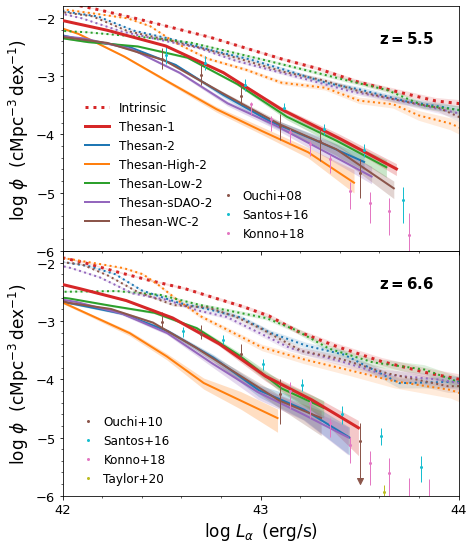

In [8]:
def plot_LFs():
    sims = ['Thesan-1', 'Thesan-2', 'Thesan-High-2', 'Thesan-Low-2', 'Thesan-sDAO-2', 'Thesan-WC-2']
    colors = {'Thesan-1': 'C3', 'Thesan-2': 'C0', 'Thesan-High-2': 'C1', 'Thesan-Low-2': 'C2', 'Thesan-sDAO-2': 'C4', 'Thesan-WC-2': 'C5'}
    
    fig = plt.figure(figsize=[5.5, 3.4])

    # z = 6.6
    snap = 60
    ax = plt.axes([0,0,1,1])
    
#     ax.plot(log_L_obs_sorted_6, log_phi_schechter_fit_6, label='Schechter fit', c='C0')
    kwargs = {'ms':2, 'elinewidth':1., 'lw':0., 'zorder':20, 'alpha':1.}
    p0,_,_ = ax.errorbar(log_ouchi_lum, log_ouchi_phi, [log_ouchi_lowdiff, log_ouchi_highdiff], **kwargs, marker='o', color='C5')
    ax.scatter(log_ouchi_lum[-1], -5.75, zorder=20, alpha=1., marker='v', color='C5')
    p1,_,_ = ax.errorbar(log_santos_lum, log_santos_phi, [log_santos_lowdiff, log_santos_highdiff], **kwargs, marker='o', color='C9')
    p2,_,_ = ax.errorbar(log_konno_lum, log_konno_phi, [log_konno_lowdiff, log_konno_highdiff], **kwargs, marker='o', color='C6')
    p3,_,_ = ax.errorbar(log_taylor_lum, log_taylor_phi, [log_taylor_lowdiff, log_taylor_highdiff], **kwargs, marker='o', color='C8')
    
    for sim in sims:
        
        # intrinsic LFs
        s_lya = read_Lya(snap, sim)
        Lya_int = s_lya['Lya']
        
        y_avg, y_phi, y_err = calc_hist(np.log10(Lya_int), n_0=9)
        y_avg = y_avg[:-1]; y_phi = y_phi[:-1]; y_err = y_err[:-1]; # Remove tail
        y_phi /= s_lya['V_box_cMpc3']; y_err /= s_lya['V_box_cMpc3']; # Volume normalization
        y_low = y_phi-y_err
        y_high = y_phi+y_err
        
        ax.fill_between(y_avg, np.log10(y_low), np.log10(y_high), lw=0., color=colors[sim], alpha=.15)
        if sim=='Thesan-1':
            ax.plot(y_avg, np.log10(y_phi), c=colors[sim], lw=3., ls=':', label='Intrinsic')
        else:
            ax.plot(y_avg, np.log10(y_phi), c=colors[sim], lw=2., ls=':')
            
        # modeled LFs
        if sim=='Thesan-WC-2' or sim=='Thesan-sDAO-2':
            tau_dir = f'/nfs/mvogelsblab001/Lab/thesan-lya/{sim}/tau'
        elif sim=='Thesan-1':
            tau_dir = '/nfs/mvogelsblab001/Thesan/Thesan-1/postprocessing/tau'
        else:
            tau_dir=f'/pool001/users/claraxu/Thesan/{sim}/tau'
            
        with h5py.File(f'{tau_dir}/X_emulated/lf_sightlines_{snap:03d}.hdf5', 'r') as f:
            y_avg = f['y_avg'][:]
            y_phi = f['y_phi'][:,:]
            y_err = f['y_err'][:,:]

        y_phi_p = np.percentile(y_phi, percentiles, axis=1)
        y_phi_50 = y_phi_p[0]
        y_phi_16 = y_phi_p[1]
        y_phi_84 = y_phi_p[2]
        
        ax.fill_between(y_avg, np.log10(y_phi_16), np.log10(y_phi_84), lw=0., color=colors[sim], alpha=.25)
        if sim=='Thesan-1':
            ax.plot(y_avg, np.log10(y_phi_50), c=colors[sim], lw=3., label=sim, zorder=20.)
        else:
            ax.plot(y_avg, np.log10(y_phi_50), c=colors[sim], lw=2., label=sim)
    
    # labels and such
    xmin, xmax = 42, 44
    ymin, ymax = -6, -1.8
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    
#     Lxmin,Lxmax = int(np.ceil(xmin)), int(np.floor(xmax))
    ticks = [42, 43, 44]
    ax.set_xticks(ticks); ax.set_xticklabels([tick for tick in ticks], fontsize=13)
    
    ax.set_xlabel(r'log $L_{\alpha}\ \,(\rm{erg/s})$', fontsize=17)
    ax.set_ylabel(r'log $\phi\ \ (\rm{cMpc}^{-3}\,\rm{dex}^{-1})$', fontsize=17)
    ticks = [-6, -5, -4, -3, -2]
    ax.set_yticks(ticks); ax.set_yticklabels([r'$%g$' % tick for tick in ticks], fontsize=13)
    
    ax.annotate(r'${\bf z=6.6}$', (.8, 0.85), xycoords='axes fraction', fontsize=15)
    
    ax.legend([p0,p1,p2,p3], ['Ouchi+10', 'Santos+16', 'Konno+18', 'Taylor+20'],
              loc='lower left', frameon=False, borderaxespad=.5, handlelength=2.5, ncol=1, fontsize=12, handletextpad=0.)
    
    ax.minorticks_on()
    
    # z = 5.5
    ax = plt.axes([0,1,1,1])
    
    p0,_,_ = ax.errorbar(log_ouchi_lum5, log_ouchi_phi5, [log_ouchi_lowdiff5, log_ouchi_highdiff5], **kwargs, marker='o', color='C5')
    p1,_,_ = ax.errorbar(log_santos_lum5, log_santos_phi5, [log_santos_lowdiff5, log_santos_highdiff5], **kwargs, marker='o', color='C9')
    p2,_,_ = ax.errorbar(log_konno_lum5, log_konno_phi5, [log_konno_lowdiff5, log_konno_highdiff5], **kwargs, marker='o', color='C6')
    
    for sim in sims:
        if sim=='Thesan-Low-2':
            snap = 78
        else:
            snap = 80
        
        # intrinsic LFs
        s_lya = read_Lya(snap, sim)
        Lya_int = s_lya['Lya']
        
        y_avg, y_phi, y_err = calc_hist(np.log10(Lya_int), n_0=9)
        y_avg = y_avg[:-1]; y_phi = y_phi[:-1]; y_err = y_err[:-1]; # Remove tail
        y_phi /= s_lya['V_box_cMpc3']; y_err /= s_lya['V_box_cMpc3']; # Volume normalization
        y_low = y_phi-y_err
        y_high = y_phi+y_err
        
        ax.fill_between(y_avg, np.log10(y_low), np.log10(y_high), lw=0., color=colors[sim], alpha=.15)
        if sim=='Thesan-1':
            ax.plot(y_avg, np.log10(y_phi), c=colors[sim], lw=3., ls=':', label='Intrinsic')
        else:
            ax.plot(y_avg, np.log10(y_phi), c=colors[sim], lw=2., ls=':')
        
        # modeled LFs
        if sim=='Thesan-WC-2' or sim=='Thesan-sDAO-2':
            tau_dir = f'/nfs/mvogelsblab001/Lab/thesan-lya/{sim}/tau'
        elif sim=='Thesan-1':
            tau_dir = '/nfs/mvogelsblab001/Thesan/Thesan-1/postprocessing/tau'
        else:
            tau_dir=f'/pool001/users/claraxu/Thesan/{sim}/tau'
            
        with h5py.File(f'{tau_dir}/X_emulated/lf_sightlines_{snap:03d}.hdf5', 'r') as f:
            y_avg = f['y_avg'][:]
            y_phi = f['y_phi'][:,:]
            y_err = f['y_err'][:,:]

        y_phi_p = np.percentile(y_phi, percentiles, axis=1)
        y_phi_50 = y_phi_p[0]
        y_phi_16 = y_phi_p[1]
        y_phi_84 = y_phi_p[2]
        
        ax.fill_between(y_avg, np.log10(y_phi_16), np.log10(y_phi_84), lw=0., color=colors[sim], alpha=.25)
        if sim=='Thesan-1':
            ax.plot(y_avg, np.log10(y_phi_50), c=colors[sim], lw=3., label=sim, zorder=20.)
        else:
            ax.plot(y_avg, np.log10(y_phi_50), c=colors[sim], lw=2., label=sim)
    
    # labels and such
    xmin, xmax = 42, 44
    ymin, ymax = -6, -1.8
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    
#     Lxmin,Lxmax = int(np.ceil(xmin)), int(np.floor(xmax))
    ticks = [42, 43, 44]
    ax.set_xticks(ticks); ax.set_xticklabels([])
    
#     ax.set_xlabel(r'log $L_{\alpha}\ \,(\rm{erg/s})$', fontsize=15)
    ax.set_ylabel(r'log $\phi\ \ (\rm{cMpc}^{-3}\,\rm{dex}^{-1})$', fontsize=17)
#     Lymin,Lymax = int(np.ceil(ymin)), int(np.floor(ymax))
#     ticks = [-7, -6, -5, -4, -3, -2]
    ticks = [-6, -5, -4, -3, -2]
    ax.set_yticks(ticks); ax.set_yticklabels([r'$%g$' % tick for tick in ticks], fontsize=13)
    
    ax.annotate(r'${\bf z=5.5}$', (.8, 0.85), xycoords='axes fraction', fontsize=15)
    leg = ax.legend(loc='lower left', frameon=False, borderaxespad=1.5, handlelength=2., ncol=1, fontsize=12)
    ax.add_artist(leg)
    ax.legend([p0,p1,p2], ['Ouchi+08', 'Santos+16', 'Konno+18'],
              loc='lower center', frameon=False, borderaxespad=.5, handlelength=2.5, ncol=1, fontsize=12, handletextpad=0.)
    
    ax.minorticks_on()
    
    fig.savefig('../luminosity functions/LF_allsims.pdf', bbox_inches='tight', transparent=True, dpi=300, pad_inches=0.025)
    plt.show()
    
plot_LFs()